In [ ]:
#Import Kaggle Datasets Directly into Google Colab
!pip install kaggle
# make directory is .kaggle
!mkdir ~/.kaggle
# copy kaggel.json to directory
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
#https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:15<00:00, 230MB/s]
100% 2.29G/2.29G [00:15<00:00, 161MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
train_data='/content/chest_xray/train'
val_data='/content/chest_xray/val'
test_data='/content/chest_xray/test'

In [ ]:
# count the number of images in each class
import os
def count_img(dir):
  class_count={}
  for class_file in os.listdir(dir):   # class_file : is class name
    class_path=os.path.join(dir,class_file)
    if os.path.isdir(class_path):
      num_img=len( os.listdir(class_path))
      class_count[class_file]=num_img
  return class_count

train_count=count_img(train_data)
val_count=count_img(val_data)
test_count=count_img(test_data)
print('train_count: ',train_count)
print('val_count: ',val_count)
print('test_count: ',test_count)

train_count:  {'PNEUMONIA': 3875, 'NORMAL': 1341}
val_count:  {'PNEUMONIA': 8, 'NORMAL': 8}
test_count:  {'PNEUMONIA': 390, 'NORMAL': 234}


In [ ]:
############## balance data##################
# oversample
import shutil
from random import choice
from keras.preprocessing import image
normal_dir='/content/chest_xray/train/NORMAL'
pneumonia_dir = '/content/chest_xray/train/PNEUMONIA'
normal_imge=os.listdir(normal_dir)
pneumonia_imge=os.listdir(pneumonia_dir)

num_pneumonia = len(pneumonia_imge)
num_normal = len(normal_imge)

if num_normal < num_pneumonia:
    difference = num_pneumonia - num_normal
    print("num of image to create: ",difference)
        # data Agumentation
    train_datagen=ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,
                                 shear_range=0.2,horizontal_flip=True,fill_mode='nearest')
    for i in range(difference):
        img_to_copy = choice(normal_imge)  # Randomly choose image
        img_path = os.path.join(normal_dir, img_to_copy)

        # Load the image and convert it to an array
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)  # ImageDataGenerator operates on NumPy arrays
        img_array = np.expand_dims(img_array, axis=0)  # Reshape for the ImageDataGenerator

        # save them in the same directory
        aug_iter = train_datagen.flow(img_array, save_to_dir=normal_dir, save_prefix=f"aug_{i}", save_format='jpeg') #save_prefix: to avoid repeat name image

        # Generate 1 augmented image per iteration
        next(aug_iter)

num of image to create:  2534


In [ ]:
train_count=count_img(train_data)
val_count=count_img(val_data)
test_count=count_img(test_data)
print('train_count: ',train_count)
print('val_count: ',val_count)
print('test_count: ',test_count)

train_count:  {'NORMAL': 3875, 'PNEUMONIA': 3875}
val_count:  {'NORMAL': 8, 'PNEUMONIA': 8}
test_count:  {'NORMAL': 234, 'PNEUMONIA': 390}


In [ ]:
########### move images to validation ###################

from random import sample
import shutil
# subdirections
train_normal_dir=os.path.join(train_data,'NORMAL')
train_PNEUMONIA_dir=os.path.join(train_data,'PNEUMONIA')

val_normal_dir=os.path.join(val_data,'NORMAL')
val_PNEUMONIA_dir=os.path.join(val_data,'PNEUMONIA')

# num of image to move to val
#num_normal=150
#num_pneumonia=150
normal_imge=os.listdir(train_normal_dir)
pneumonia_imge=os.listdir(train_PNEUMONIA_dir)
percentage=0.1
# num of image to move to val
num_normal=int(len(normal_imge)*percentage)
num_pneumonia=int(len(pneumonia_imge)*percentage)

# select image random to move for normal
normal_move=sample(normal_imge,num_normal)
for imge in normal_move:
  imge_path=os.path.join(train_normal_dir,imge)
  shutil.move(imge_path,val_normal_dir)

# select image random to move for pneumonia
pneumonia_move=sample(pneumonia_imge,num_pneumonia)
for imge in pneumonia_move:
  imge_path=os.path.join(train_PNEUMONIA_dir,imge)
  shutil.move(imge_path,val_PNEUMONIA_dir)


In [ ]:
train_count=count_img(train_data)
val_count=count_img(val_data)
test_count=count_img(test_data)
print('train_count: ',train_count)
print('val_count: ',val_count)
print('test_count: ',test_count)

train_count:  {'NORMAL': 3488, 'PNEUMONIA': 3488}
val_count:  {'NORMAL': 395, 'PNEUMONIA': 395}
test_count:  {'NORMAL': 234, 'PNEUMONIA': 390}


In [ ]:
############## balance test data ##################
# oversample
import shutil
from random import choice
from keras.preprocessing import image
normal_dir='/content/chest_xray/test/NORMAL'
pneumonia_dir = '/content/chest_xray/test/PNEUMONIA'
normal_imge=os.listdir(normal_dir)
pneumonia_imge=os.listdir(pneumonia_dir)

num_pneumonia = len(pneumonia_imge)
num_normal = len(normal_imge)

if num_normal < num_pneumonia:
    difference = num_pneumonia - num_normal
    print("num of image to create: ",difference)
        # data Agumentation
    test_datagen=ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,
                                 shear_range=0.2,horizontal_flip=True,fill_mode='nearest')
    for i in range(difference):
        img_to_copy = choice(normal_imge)  # Randomly choose image
        img_path = os.path.join(normal_dir, img_to_copy)

        # Load the image and convert it to an array
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)  # ImageDataGenerator operates on NumPy arrays
        img_array = np.expand_dims(img_array, axis=0)  # Reshape for the ImageDataGenerator

        # save them in the same directory
        aug_iter = test_datagen.flow(img_array, save_to_dir=normal_dir, save_prefix=f"aug_{i}", save_format='jpeg') #save_prefix: to avoid repeat name image

        # Generate 1 augmented image per iteration
        next(aug_iter)

num of image to create:  156


In [ ]:
train_count=count_img(train_data)
val_count=count_img(val_data)
test_count=count_img(test_data)
print('train_count: ',train_count)
print('val_count: ',val_count)
print('test_count: ',test_count)

train_count:  {'NORMAL': 3488, 'PNEUMONIA': 3488}
val_count:  {'NORMAL': 395, 'PNEUMONIA': 395}
test_count:  {'NORMAL': 390, 'PNEUMONIA': 390}


In [ ]:
# Data preprocessing
image_size=(224,224)
Batch_size=32
   # data Agumentation
train_datagen=ImageDataGenerator(rescale=1./255,rotation_range=20,zoom_range=0.2,width_shift_range=0.2,height_shift_range=0.2,
                                 shear_range=0.2,horizontal_flip=True,fill_mode='nearest')  # prevent overfitting

val_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)
   #load data
train_generator=train_datagen.flow_from_directory(
     train_data,
     target_size=image_size,
     batch_size=Batch_size,
     class_mode='binary'   # (normal,penumiem)
)
val_generator=val_datagen.flow_from_directory(
    val_data,
    target_size=image_size,
    batch_size=Batch_size,
    class_mode='binary'
)
test_generator=test_datagen.flow_from_directory(
    test_data,
    target_size=image_size,
    batch_size=Batch_size,
    class_mode='binary',
    shuffle=False
)

Found 6976 images belonging to 2 classes.
Found 790 images belonging to 2 classes.
Found 780 images belonging to 2 classes.


#VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten,Dropout

base_model=VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))

for layer in base_model.layers:
  layer.trainable=False

x=base_model.output
x=Flatten()(x)
x=Dense(256,activation='relu')(x)
#x=Dropout(0.5)(x)
#x=Dense(128,activation='relu')(x)
x=Dropout(0.5)(x)
output_vgg=Dense(1,activation='sigmoid')(x)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model_vgg=Model(inputs=base_model.input,outputs=output_vgg)
# compile model
model_vgg.compile(optimizer=Adam(learning_rate=0.00001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
# Early stopping to avoid overfitting
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
# Learning Rate Scheduling to reduce it when validation stop improve
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# train model
Epochs=30
history=model_vgg.fit(train_generator,validation_data=val_generator,epochs=Epochs,
                  steps_per_epoch=train_generator.samples//Batch_size,  # 5216/32=163
                  validation_steps=val_generator.samples//Batch_size,
                  callbacks=[reduce_lr,early_stop]
                  )

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


218/218 ━━━━━━━━━━━━━━━━━━━━ 143s 562ms/step - accuracy: 0.7033 - loss: 0.5552 - val_accuracy: 0.9336 - val_loss: 0.2378 - learning_rate: 1.0000e-05
Epoch 2/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


218/218 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9545 - val_loss: 0.2320 - learning_rate: 1.0000e-05
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 124s 553ms/step - accuracy: 0.8888 - loss: 0.2986 - val_accuracy: 0.9414 - val_loss: 0.1967 - learning_rate: 1.0000e-05
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1113 - learning_rate: 1.0000e-05
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 124s 553ms/step - accuracy: 0.9032 - loss: 0.2532 - val_accuracy: 0.9453 - val_loss: 0.1764 - learning_rate: 1.0000e-05
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8636 - val_loss: 0.2091 - learning_rate: 1.0000e-05
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 124s 551ms/step - accuracy: 0.9172 - loss: 0.2251 - val_accuracy: 0.9362 - val_loss: 0.1917 - learning_rate: 1.0000e-05
Epoch 8/30
218/218 ━━━━━━━━━━━━━━━━

In [ ]:
'''from tensorflow.keras import backend as K
# Clear session to free up resources to avoid memory buildup.
K.clear_session()
# fine tuning by un freezing some layers
for layer in base_model.layers[-8:]:
  layer.trainable=True
  # reduce learning rate
epochs=10
Batch_size=16
model_vgg.compile(optimizer=Adam(learning_rate=0.00001),loss='binary_crossentropy',metrics=['accuracy'])
history_fine_tune=model_vgg.fit(train_generator,validation_data=val_generator,epochs=epochs,
                  steps_per_epoch=train_generator.samples//Batch_size,  # 5216/32=163
                  validation_steps=val_generator.samples//Batch_size,
                  callbacks=[early_stop]
                  )'''

Epoch 1/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 150s 307ms/step - accuracy: 0.9373 - loss: 0.1693 - val_accuracy: 0.8620 - val_loss: 0.3295
Epoch 2/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 136s 301ms/step - accuracy: 0.9556 - loss: 0.1206 - val_accuracy: 0.9089 - val_loss: 0.2672
Epoch 3/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 138s 308ms/step - accuracy: 0.9637 - loss: 0.0972 - val_accuracy: 0.9430 - val_loss: 0.1866
Epoch 4/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 137s 305ms/step - accuracy: 0.9679 - loss: 0.0865 - val_accuracy: 0.9557 - val_loss: 0.1140
Epoch 5/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 139s 307ms/step - accuracy: 0.9709 - loss: 0.0749 - val_accuracy: 0.9532 - val_loss: 0.1518
Epoch 6/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 140s 305ms/step - accuracy: 0.9752 - loss: 0.0754 - val_accuracy: 0.9456 - val_loss: 0.1600
Epoch 7/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 141s 315ms/step - accuracy: 0.9769 - loss: 0.0637 - val_accuracy: 0.9709 - val_loss: 0.0931
Epoch 8/10
436/436 ━━━━━━━━━━━━━━━━━━━━ 137s 304ms/step - accuracy: 0.9733 -

In [ ]:
# evaluation
test_loss,test_acc=model_vgg.evaluate(test_generator)
print('test accuracy : ',test_acc)
print('test loss : ',test_loss)

25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 510ms/step - accuracy: 0.7081 - loss: 0.6292
test accuracy :  0.8179486989974976
test loss :  0.42056453227996826


In [ ]:
# save model for deployment
#keras.saving.save_model(model_vgg, 'my_model.keras')
model_vgg.save('pneumonia_detection.keras')

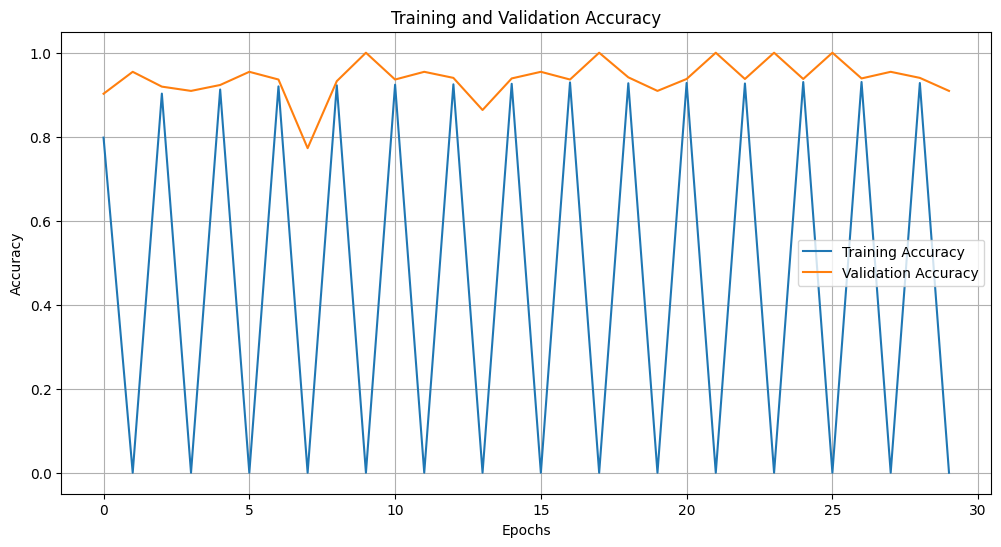

In [ ]:
# Visualize training and validation accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# prediction
y_predict=model_vgg.predict(test_generator)
y_predict

25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 411ms/step


array([[2.33955942e-02],
       [2.22147983e-02],
       [6.82960637e-03],
       [8.02957453e-03],
       [1.78941339e-02],
       [4.99507505e-03],
       [2.37459149e-02],
       [4.85366918e-02],
       [3.57183635e-01],
       [1.01451213e-02],
       [3.31098330e-04],
       [2.52167493e-01],
       [3.44004040e-03],
       [7.01478403e-03],
       [5.33321761e-02],
       [1.47437945e-01],
       [9.96313035e-01],
       [2.68265116e-03],
       [1.61020725e-03],
       [1.31092370e-02],
       [5.34144305e-02],
       [3.13800550e-03],
       [8.44119191e-02],
       [2.31827218e-02],
       [6.03882909e-01],
       [6.90396223e-03],
       [1.08314589e-01],
       [2.28986680e-03],
       [8.64644408e-01],
       [2.80012846e-01],
       [6.70424759e-01],
       [1.28379511e-03],
       [5.31522930e-03],
       [6.76212600e-04],
       [3.33279669e-02],
       [1.27845118e-02],
       [1.11510293e-04],
       [7.96167995e-04],
       [5.77514898e-03],
       [2.99689767e-04],


In [ ]:
y_predict_classes=np.where(y_predict>0.5,1,0)

[[271 119]
 [  3 387]]


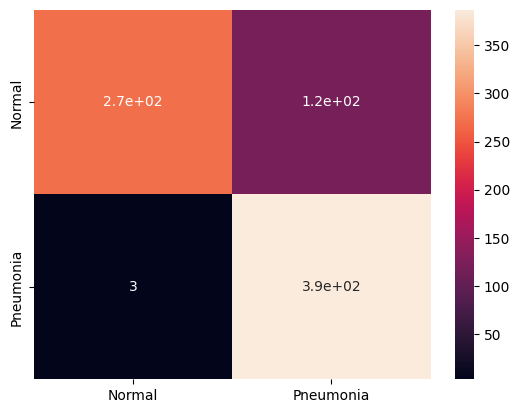

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt
con_metrx=confusion_matrix(test_generator.classes,y_predict_classes)
print(con_metrx)
sns.heatmap(con_metrx,annot=True,xticklabels=['Normal','Pneumonia'],yticklabels=['Normal','Pneumonia'])
#plt.ylabel('actual',fontsize=13)
#plt.ylabel('predict',fontsize=13)
plt.show()

In [ ]:
class_report=classification_report(test_generator.classes,y_predict_classes,)
print(class_report)

              precision    recall  f1-score   support

           0       0.99      0.69      0.82       390
           1       0.76      0.99      0.86       390

    accuracy                           0.84       780
   macro avg       0.88      0.84      0.84       780
weighted avg       0.88      0.84      0.84       780



In [ ]:
!pip install --upgrade tensorflow

#ResNet50

In [ ]:
# Model selection
  #transfer learning(ResNet50)
from tensorflow.keras.layers import Dropout
base_model=ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
base_model.trainable=False
x=base_model.output
x=GlobalAveragePooling2D()(x)
#x=Dense(1024,activation='relu')(x)
#x=Dense(512,activation='relu')(x)
x=Dense(128,activation='relu')(x)
x=Dropout(0.2)(x)
output=Dense(1,activation='sigmoid')(x)   # final output to be a single value between 0 and 1

# Model
model=Model(inputs=base_model.input,outputs=output)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# compile model
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
# train model
Epochs=15
history=model.fit(train_generator,validation_data=val_generator,epochs=Epochs,
                  steps_per_epoch=train_generator.samples//Batch_size,  # 5216/32=163
                  validation_steps=val_generator.samples//Batch_size
                  )

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


196/196 ━━━━━━━━━━━━━━━━━━━━ 140s 626ms/step - accuracy: 0.4968 - loss: 0.7286 - val_accuracy: 0.5014 - val_loss: 0.6717
Epoch 2/15
  1/196 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.5938 - loss: 0.6860

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5938 - loss: 0.6860 - val_accuracy: 0.5000 - val_loss: 0.6732
Epoch 3/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 125s 585ms/step - accuracy: 0.5890 - loss: 0.6737 - val_accuracy: 0.6848 - val_loss: 0.6481
Epoch 4/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - accuracy: 0.7812 - loss: 0.6197 - val_accuracy: 0.6429 - val_loss: 0.6504
Epoch 5/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 117s 583ms/step - accuracy: 0.6540 - loss: 0.6532 - val_accuracy: 0.8118 - val_loss: 0.6242
Epoch 6/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step - accuracy: 0.6562 - loss: 0.6542 - val_accuracy: 0.7857 - val_loss: 0.6211
Epoch 7/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 118s 586ms/step - accuracy: 0.6900 - loss: 0.6353 - val_accuracy: 0.7874 - val_loss: 0.6029
Epoch 8/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.7188 - loss: 0.6288 - val_accuracy: 0.8571 - val_loss: 0.5893
Epoch 9/15
196/196 ━━━━━━━━━━━━━━━━━━━━ 141s 580ms/step - accuracy: 0.7236 - loss: 0.6188 - val_

In [ ]:
# evaluation
test_loss,test_acc=model.evaluate(test_generator)
print('test accuracy : ',test_acc)
print('test loss : ',test_loss)

25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 300ms/step - accuracy: 0.7709 - loss: 0.5599
test accuracy :  0.7974358797073364
test loss :  0.5522757768630981


In [ ]:
# prediction
y_predict=model.predict(test_generator)
y_predict

25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 283ms/step


array([[0.3327287 ],
       [0.41199294],
       [0.42795303],
       [0.6200402 ],
       [0.40490428],
       [0.37288457],
       [0.5436838 ],
       [0.5366731 ],
       [0.4546201 ],
       [0.5593275 ],
       [0.43881977],
       [0.4915667 ],
       [0.32934287],
       [0.57476145],
       [0.4679221 ],
       [0.57319224],
       [0.7096949 ],
       [0.46222648],
       [0.4033606 ],
       [0.53828317],
       [0.35824156],
       [0.5414036 ],
       [0.40611959],
       [0.4265193 ],
       [0.40801874],
       [0.34506115],
       [0.40855542],
       [0.31424236],
       [0.37780437],
       [0.4846284 ],
       [0.36698356],
       [0.48556975],
       [0.49920696],
       [0.36932743],
       [0.47814727],
       [0.40130544],
       [0.45118994],
       [0.4833338 ],
       [0.19239041],
       [0.3479661 ],
       [0.37480995],
       [0.34459594],
       [0.35140172],
       [0.2984674 ],
       [0.3995989 ],
       [0.38347065],
       [0.36070833],
       [0.492

In [ ]:
y_predict_classes=np.where(y_predict>0.5,1,0)  # convert to binary # Pneumonia(1),normal(0)

[[300  90]
 [ 68 322]]


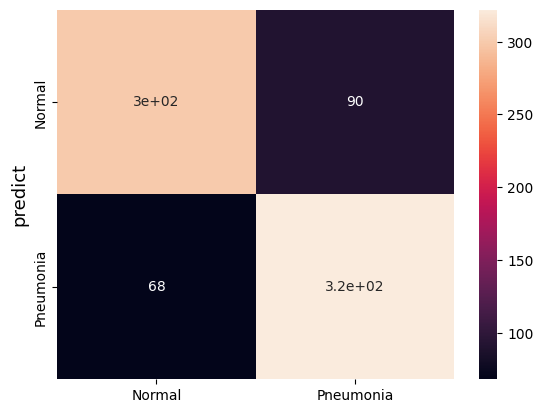

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt
con_metrx=confusion_matrix(test_generator.classes,y_predict_classes)
print(con_metrx)
sns.heatmap(con_metrx,annot=True,xticklabels=['Normal','Pneumonia'],yticklabels=['Normal','Pneumonia'])
#plt.ylabel('actual',fontsize=13)
plt.ylabel('predict',fontsize=13)
plt.show()

In [ ]:
class_report=classification_report(test_generator.classes,y_predict_classes,)
print(class_report)

              precision    recall  f1-score   support

           0       0.82      0.77      0.79       390
           1       0.78      0.83      0.80       390

    accuracy                           0.80       780
   macro avg       0.80      0.80      0.80       780
weighted avg       0.80      0.80      0.80       780

